In [1]:
import os
import glob
import cv2
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.python.keras.layers.convolutional import MaxPooling2D, Convolution2D
from tensorflow.python.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential
import argparse
from keras import regularizers
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
path = "./data/planes/"

Using TensorFlow backend.


In [3]:
#读取图像
def read_img(path):
    cate = [path + x for x in os.listdir(path) if os.path.isdir(path + x)]
    imgs = []
    labels = []
    fpath = []
    for idx, folder in enumerate(cate):
        # 遍历整个目录判断每个文件是不是符合
        for im in glob.glob(folder + '/*.jpg'):
            IMG_SIZE = 224
            # print('reading the images:%s' % (im))
            try:
             img = cv2.imread(im)
             # img = Image.open(im).convert("RGB")  # 调用PIL库读取该图像
             # # 将rgb通道转换为bgr
             # img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
             # # print(img.shape)
             img = cv2.resize(img, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_CUBIC)  # 图像像素大小一致
             # print(img.shape)
             imgs.append(img)  # 图像数据
             labels.append(idx)  # 图像类标
             fpath.append(path + im)  # 图像路径名
             # print(path+im, idx)
            except:
                continue

    return np.asarray(fpath, np.string_), np.asarray(imgs, np.float32)/255, np.asarray(labels, np.int32)

In [22]:
# 读取图像
fpaths, data, label = read_img(path)
print(data.shape)  # (7641, 28, 28, 3)
# data=np.transpose(data,(0,3,1,2))
# 计算有多少类图片
num_classes = len(set(label))
print(num_classes)
# 生成等差数列随机调整图像顺序
num_example = data.shape[0]
# print(num_example)
arr = np.arange(num_example)
np.random.shuffle(arr)
data = data[arr]
label = label[arr]
fpaths = fpaths[arr]
# 拆分训练集和测试集 80%训练集 20%测试集
ratio = 0.8
s = np.int(num_example * ratio)
x_train = data[:s]
y_train = label[:s]
fpaths_train = fpaths[:s]
x_val = data[s:]
y_val = label[s:]
fpaths_test = fpaths[s:]
# 6824 6824 1706 1706
print(len(x_train),len(y_train),len(x_val),len(y_val))
lb=LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_val=lb.fit_transform(y_val)
print(y_train)

(7641, 224, 224, 3)
6
6112 6112 1529 1529
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]]


(7641, 224, 224, 3)
6
6112 6112 1529 1529
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 ...
 [0 0 0 0 0 1]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]]

In [6]:
#GPU加速
import os
import tensorflow as tf
os.environ["CUDA_DEVICES_ORDER"] = "PCI_BUS_IS"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# # 建立基础的神经网络
# model=Sequential()
# model.add(Convolution2D(filters = 32,kernel_size = 5,strides = 1,padding = 'same',input_shape = (28,28,3)))
# # 增加神经网络激活函数
# model.add(Activation('relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# # 池化层利用MaxPooling2D
# model.add(MaxPooling2D(
#     pool_size = (2, 2),             # 向下取样
#     strides = (2,2),                # 取样跳2个
#     padding='same',                 # Padding method
# ))
# model.add(tf.keras.layers.Dropout(0.5))  # 加上DropOut防止过拟合
# model.add(Convolution2D(64, 5, 5, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = (2, 2), padding='same'))
# model.add(Flatten())                  # 将三维层拉直
# model.add(Dense(64))                # 全连接层
# model.add(Activation('relu'))         # 激励函数
# model.add(Dense(6))                  # 输出6个单位
# model.add(Activation('softmax'))      # 分类激励函数
# LR=0.001
# EPOCHS=300
# # 定义优化器 学习效率设置为0.001
# opt =SGD(lr=LR)
#建立AlexNet模型
def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
    #第一层卷积
    #卷积核数量96 尺寸11*11 步长4 激活函数relu
    #最大池化 尺寸3*3，步长2
    model = Sequential()
    model.add(Convolution2D(filters=96, 
                     kernel_size=11, 
                     strides=4,
                     input_shape=(224, 224, 3), 
                     activation=activation))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    
    #第二层卷积
    #卷积核数量256 尺寸5*5 激活函数relu same卷积
    #最大池化 尺寸3*3，步长2
    model.add(Convolution2D(filters=256, 
                     kernel_size=5, 
                     padding='same',
                     activation=activation))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    
    #第三层卷积
    #卷积核数量384 尺寸3 激活函数relu same卷积
    model.add(Convolution2D(filters=384, 
                     kernel_size=3, 
                     padding='same',
                     activation=activation))

    #第四层卷积
    #卷积核数量384 尺寸3 激活函数relu same卷积
    model.add(Convolution2D(filters=384, 
                     kernel_size=3, 
                     padding='same',
                     activation=activation))
    
    #第五层卷积
    #卷积核数量256 尺寸3 激活函数relu same卷积
    #最大池化 尺寸3*3，步长2
    model.add(Convolution2D(filters=256, 
                     kernel_size=3, 
                     padding='same',
                     activation=activation))
    model.add(MaxPooling2D(pool_size=3, strides=2))
    
    #展平特征图
    model.add(Flatten())
    
    #第一个全连接 1024神经元 relu
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    #第二个全连接 4096神经元 relu
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
   
    #第二个全连接 输出6类结果
    model.add(Dense(6, activation='softmax'))
    # 定义损失函数-
    model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
    return model
#创建模型
optimizer =tf.train.AdamOptimizer(learning_rate=1e-4)
model = create_model(optimizer, 
                     kernel_initializer='uniform', 
                     activation='relu')



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


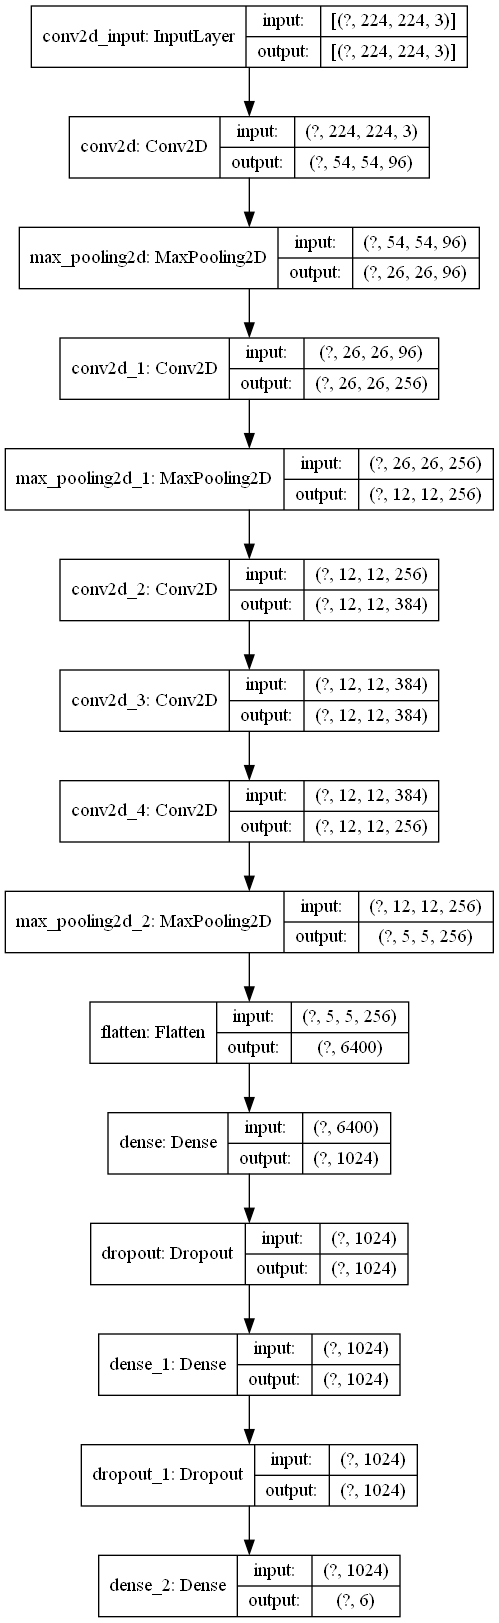

In [9]:
from tensorflow.keras.utils import  plot_model
from IPython.display import Image as IPythonImage
plot_model(model, to_file="AlexNet-model.png", show_shapes=True)
display(IPythonImage('AlexNet-model.png'))
os.environ["PATH"] += os.pathsep + ':C:/Program Files/Graphviz/bin'

#绘制图形
def plot_loss_accuracy(history):
    # Loss 
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

In [20]:

# 模型训练
h=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=30,batch_size=64)

Train on 6112 samples, validate on 1529 samples
Epoch 1/30
6112/6112 [==============================] - 107s 18ms/sample - loss: 1.7717 - acc: 0.2165 - val_loss: 1.7385 - val_acc: 0.2825
Epoch 2/30
6112/6112 [==============================] - 111s 18ms/sample - loss: 1.6891 - acc: 0.2775 - val_loss: 1.7177 - val_acc: 0.2636
Epoch 3/30
6112/6112 [==============================] - 113s 18ms/sample - loss: 1.6062 - acc: 0.3279 - val_loss: 1.5346 - val_acc: 0.3669
Epoch 4/30
6112/6112 [==============================] - 115s 19ms/sample - loss: 1.5553 - acc: 0.3652 - val_loss: 1.5112 - val_acc: 0.3911
Epoch 5/30
6112/6112 [==============================] - 115s 19ms/sample - loss: 1.4892 - acc: 0.3958 - val_loss: 1.4625 - val_acc: 0.4081
Epoch 6/30
6112/6112 [==============================] - 116s 19ms/sample - loss: 1.4409 - acc: 0.4231 - val_loss: 1.4132 - val_acc: 0.4330
Epoch 7/30
6112/6112 [==============================] - 117s 19ms/sample - loss: 1.3758 - acc: 0.4548 - val_loss: 1.37

Output exceeds the size limit. Open the full output data in a text editor
Train on 6112 samples, validate on 1529 samples
Epoch 1/30
6112/6112 [==============================] - 107s 18ms/sample - loss: 1.7717 - acc: 0.2165 - val_loss: 1.7385 - val_acc: 0.2825
Epoch 2/30
6112/6112 [==============================] - 111s 18ms/sample - loss: 1.6891 - acc: 0.2775 - val_loss: 1.7177 - val_acc: 0.2636
Epoch 3/30
6112/6112 [==============================] - 113s 18ms/sample - loss: 1.6062 - acc: 0.3279 - val_loss: 1.5346 - val_acc: 0.3669
Epoch 4/30
6112/6112 [==============================] - 115s 19ms/sample - loss: 1.5553 - acc: 0.3652 - val_loss: 1.5112 - val_acc: 0.3911
Epoch 5/30
6112/6112 [==============================] - 115s 19ms/sample - loss: 1.4892 - acc: 0.3958 - val_loss: 1.4625 - val_acc: 0.4081
Epoch 6/30
6112/6112 [==============================] - 116s 19ms/sample - loss: 1.4409 - acc: 0.4231 - val_loss: 1.4132 - val_acc: 0.4330
Epoch 7/30
6112/6112 [==============================] - 117s 19ms/sample - loss: 1.3758 - acc: 0.4548 - val_loss: 1.3768 - val_acc: 0.4500
Epoch 8/30
6112/6112 [==============================] - 116s 19ms/sample - loss: 1.3254 - acc: 0.4786 - val_loss: 1.3614 - val_acc: 0.4519
Epoch 9/30
6112/6112 [==============================] - 116s 19ms/sample - loss: 1.2863 - acc: 0.4948 - val_loss: 1.3596 - val_acc: 0.4617
Epoch 10/30
6112/6112 [==============================] - 112s 18ms/sample - loss: 1.2150 - acc: 0.5299 - val_loss: 1.3218 - val_acc: 0.4840
Epoch 11/30
6112/6112 [==============================] - 110s 18ms/sample - loss: 1.1653 - acc: 0.5507 - val_loss: 1.3353 - val_acc: 0.4794
Epoch 12/30
6112/6112 [==============================] - 110s 18ms/sample - loss: 1.1084 - acc: 0.5769 - val_loss: 1.3174 - val_acc: 0.4644
...
Epoch 29/30
6112/6112 [==============================] - 114s 19ms/sample - loss: 0.2328 - acc: 0.8971 - val_loss: 2.5193 - val_acc: 0.4977
Epoch 30/30
6112/6112 [==============================] - 115s 19ms/sample - loss: 0.2133 - acc: 0.9038 - val_loss: 2.3431 - val_acc: 0.4748

In [21]:
# 模型测试
predicts=model.predict(x_val,batch_size=64)
loss, accuracy = model.evaluate(x_val, y_val)
print('\ntest loss: ', loss) 

print('\ntest accuracy: ', accuracy)
print(classification_report(y_val.argmax(axis=1),
                                predicts.argmax(axis=1), target_names=["drone","fighter-jet","helicopter","missile","passenger-plane","rocket"]))

1529/1529 [==============================] - 6s 4ms/sample - loss: 2.3431 - acc: 0.4748

test loss:  2.3431241329859254

test accuracy:  0.47482014
                 precision    recall  f1-score   support

          drone       0.58      0.35      0.44       221
    fighter-jet       0.37      0.40      0.38       338
     helicopter       0.80      0.66      0.72       253
        missile       0.43      0.61      0.51       236
passenger-plane       0.45      0.55      0.49       254
         rocket       0.37      0.28      0.32       227

       accuracy                           0.47      1529
      macro avg       0.50      0.47      0.48      1529
   weighted avg       0.49      0.47      0.47      1529



1529/1529 [==============================] - 6s 4ms/sample - loss: 2.3431 - acc: 0.4748

test loss:  2.3431241329859254

test accuracy:  0.47482014
                 precision    recall  f1-score   support

          drone       0.58      0.35      0.44       221
    fighter-jet       0.37      0.40      0.38       338
     helicopter       0.80      0.66      0.72       253
        missile       0.43      0.61      0.51       236
passenger-plane       0.45      0.55      0.49       254
         rocket       0.37      0.28      0.32       227

       accuracy                           0.47      1529
      macro avg       0.50      0.47      0.48      1529
   weighted avg       0.49      0.47      0.47      1529
